# Interacting particles in a box

In [1]:
import CairoMakie as cm

include("../src/verlet.jl")

calc_lj_hamiltonian (generic function with 1 method)

In [2]:
dt = 0.000_1
cutoff = 2.5
box_size = 20.0
pos_arr = verlet_simulate(N_particles=50, steps=100_000,L=box_size, dt=dt,cutoff=cutoff)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03K


100001×50×3 Array{Float64, 3}:
[:, :, 1] =
 4.07335  3.93105  18.8243  7.46851  …  3.88032  7.45168  0.660345  12.2603
 4.07335  3.93105  18.8243  7.46851     3.88032  7.45168  0.660345  12.2603
 4.07335  3.93105  18.8243  7.46851     3.88032  7.45168  0.660345  12.2603
 4.07335  3.93105  18.8243  7.46851     3.88032  7.45168  0.660345  12.2603
 4.07335  3.93105  18.8243  7.46851     3.88032  7.45168  0.660345  12.2603
 4.07335  3.93105  18.8243  7.46851  …  3.88032  7.45168  0.660345  12.2603
 4.07335  3.93105  18.8243  7.46851     3.88032  7.45168  0.660345  12.2603
 4.07335  3.93105  18.8243  7.46851     3.88032  7.45168  0.660345  12.2603
 4.07335  3.93105  18.8243  7.46851     3.88032  7.45168  0.660345  12.2603
 4.07335  3.93105  18.8243  7.46851     3.88032  7.45168  0.660345  12.2603
 ⋮                                   ⋱                              
 4.07335  3.92586  18.8243  7.3876      3.88551  7.15979  0.660345  12.2603
 4.07335  3.92586  18.8243  7.38765     3.8855   7.1

In [3]:
v = sb.mean(calc_mean_velocity(pos_arr, dt=dt),dims=3)
v = reshape(v,length(v))
t = collect(range(0,length(v)*dt,length(v)));

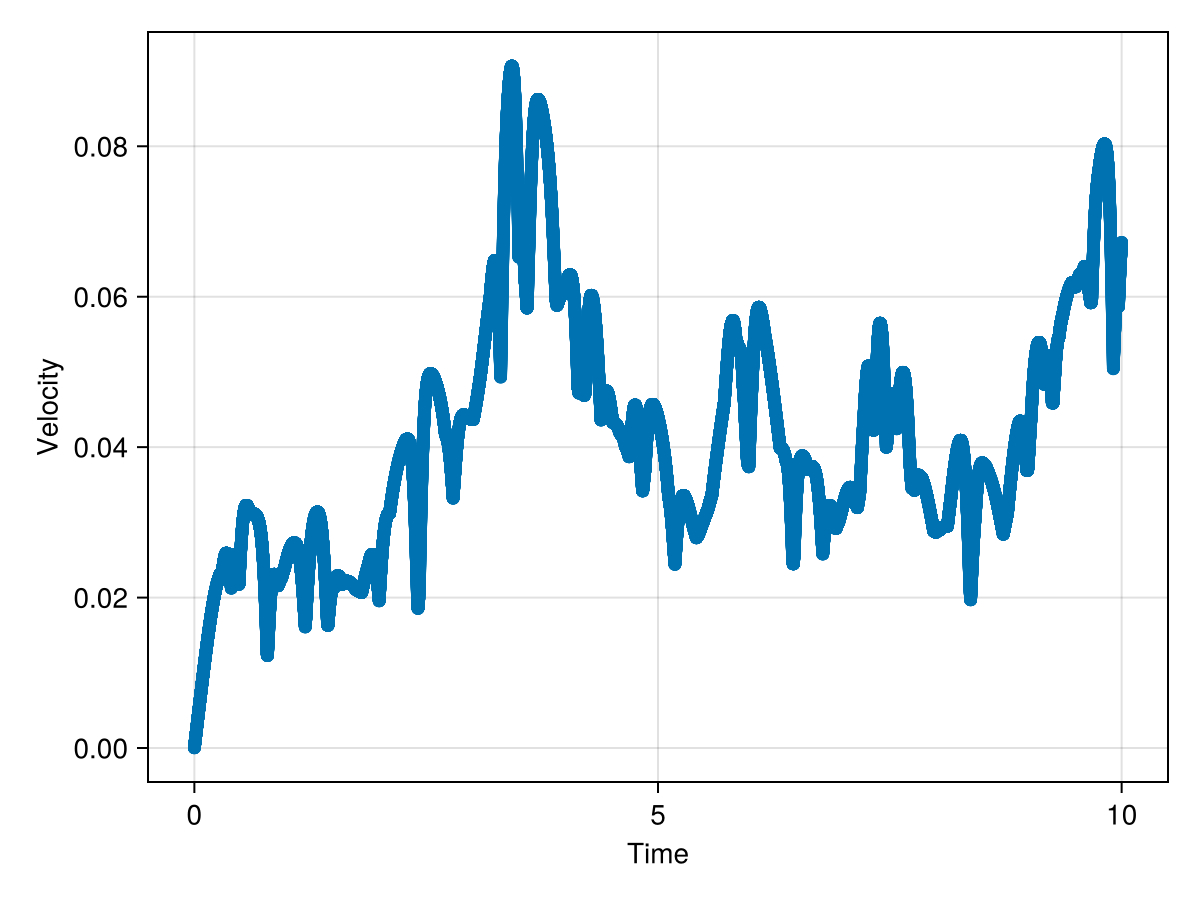

In [4]:
fig = cm.Figure()
ax = cm.Axis(fig[1, 1], xlabel="Time", ylabel="Velocity")
cm.plot!(ax, t, v)

fig

In [5]:
energy = calc_lj_hamiltonian(pos_arr, dt=dt, cutoff=cutoff,L=box_size)
t = collect(range(0,length(energy)*dt,length(energy)));

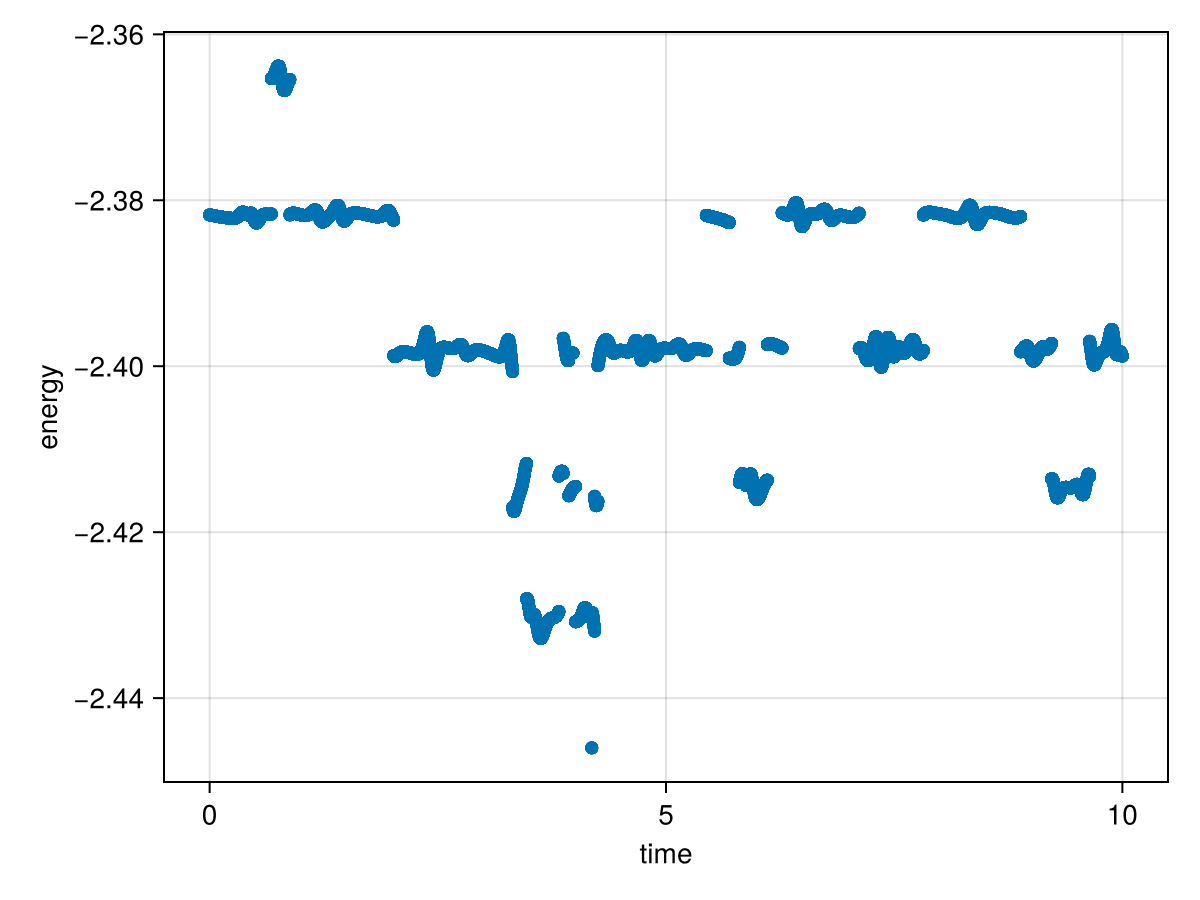

In [6]:
fig = cm.Figure()
ax = cm.Axis(fig[1,1],xlabel="time", ylabel="energy")

cm.plot!(ax, t, energy)


# cm.xlims!(ax, 0, 0.2)
# cm.ylims!(ax, 8000, 8300)


fig